<a href="https://colab.research.google.com/github/raflinoob132/MachineLearning-1/blob/main/UAS/uas_klasifikasi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# UAS MACHINE LEARNING - DEEP LEARNING CLASSIFICATION PIPELINE
# =============================================

# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           confusion_matrix, roc_auc_score, roc_curve, classification_report)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1, l2, l1_l2

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR, CosineAnnealingWarmRestarts

print("TensorFlow version:", tf.__version__)
print("PyTorch version:", torch.__version__)

TensorFlow version: 2.18.0
PyTorch version: 2.6.0+cu124


In [ ]:
# =============================================
# 1. PENGUMPULAN & PEMBERSIHAN DATA
# =============================================

# Download dataset
file_id = '1au6HqbGWpBCszFFBjZ4YmdpnqhThnTlU'
file_name = 'dataset.csv'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output=file_name, quiet=False)

# Load dataset
df = pd.read_csv(file_name)
print("Dataset shape:", df.shape)
print("\nDataset info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

# Identifikasi target column (column pertama dengan dtype int)
target_col = None
for col in df.columns:
    if df[col].dtype in ['int64', 'int32']:
        target_col = col
        break

print(f"\nTarget column: {target_col}")
print(f"Target column dtype: {df[target_col].dtype}")

# Analisis target untuk klasifikasi
print(f"\nTarget value counts:")
print(df[target_col].value_counts().sort_index())
print(f"Unique values: {df[target_col].nunique()}")
print(f"Target range: {df[target_col].min()} to {df[target_col].max()}")

# Data cleaning
print("\nMissing values:")
print(df.isnull().sum())

# Handle missing values
df = df.dropna()
print(f"\nDataset shape after removing missing values: {df.shape}")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Dataset shape after removing duplicates: {df.shape}")

# Basic statistics
print("\nBasic statistics:")
print(df.describe())

Downloading...
From (original): https://drive.google.com/uc?id=1au6HqbGWpBCszFFBjZ4YmdpnqhThnTlU
From (redirected): https://drive.google.com/uc?id=1au6HqbGWpBCszFFBjZ4YmdpnqhThnTlU&confirm=t&uuid=36046c8a-401b-48fa-a8c8-2e235677e0d1
To: /content/dataset.csv
100%|██████████| 151M/151M [00:01<00:00, 116MB/s]


Dataset shape: (284807, 31)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20  

In [ ]:
# =============================================
# 2. FEATURE ENGINEERING
# =============================================

# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col].values

# Convert target to binary classification if needed (optional)
# Uncomment jika ingin binary classification
# y_binary = (y > y.mean()).astype(int)
# print(f"Binary target distribution: {np.bincount(y_binary)}")

# Untuk multi-class, encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
n_classes = len(np.unique(y_encoded))

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y_encoded.shape}")
print(f"Number of classes: {n_classes}")
print(f"Class distribution: {np.bincount(y_encoded)}")

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ]
)

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)
print(f"\nProcessed features shape: {X_processed.shape}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"\nTrain set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")


Features shape: (283726, 30)
Target shape: (283726,)
Number of classes: 2
Class distribution: [283253    473]

Categorical columns: []
Numerical columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

Processed features shape: (283726, 30)

Train set: (181584, 30)
Validation set: (45396, 30)
Test set: (56746, 30)


In [ ]:
# =============================================
# 3. MODEL TENSORFLOW/KERAS
# =============================================

def create_tensorflow_model(input_dim, n_classes):
    """Create MLP classification model with advanced techniques"""
    model = keras.Sequential([
        layers.Dense(256, input_dim=input_dim),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),

        layers.Dense(128),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),

        layers.Dense(64),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.2),

        layers.Dense(32, kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        layers.Activation('relu'),
        layers.Dropout(0.2),

        layers.Dense(1 if n_classes == 2 else n_classes, activation='sigmoid' if n_classes == 2 else 'softmax') # Modified line
    ])

    return model

# Create TensorFlow model
tf_model = create_tensorflow_model(X_train.shape[1], n_classes)

# Compile model dengan optimizer modern
optimizer = keras.optimizers.AdamW(
    learning_rate=0.001,
    weight_decay=0.01
)

# Loss function berdasarkan jumlah kelas
loss_function = 'sparse_categorical_crossentropy' if n_classes > 2 else 'binary_crossentropy'
metrics = ['accuracy']

tf_model.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=metrics
)

print("\nTensorFlow Model Architecture:")
tf_model.summary()

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7
)

# Train TensorFlow model
print("\nTraining TensorFlow model...")
tf_history = tf_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,  # Reduced epochs
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


TensorFlow Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,993 (207.00 KB)

 Trainable params: 52,097 (203.50 KB)

 Non-trainable params: 896 (3.50 KB)


Training TensorFlow model...
Epoch 1/30
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.9947 - loss: 0.3198 - val_accuracy: 0.9983 - val_loss: 0.0231 - learning_rate: 0.0010
Epoch 2/30
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.9984 - loss: 0.0202 - val_accuracy: 0.9983 - val_loss: 0.0204 - learning_rate: 0.0010
Epoch 3/30
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.9983 - loss: 0.0214 - val_accuracy: 0.9983 - val_loss: 0.0213 - learning_rate: 0.0010
Epoch 4/30
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.9983 - loss: 0.0191 - val_accuracy: 0.9983 - val_loss: 0.0121 - learning_rate: 0.0010
Epoch 5/30
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.9986 - loss: 0.0184 - val_accuracy: 0.9995 - val_loss: 0.0180 - learning_rate: 0.0010
Epoch 6/30
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.9987 - loss: 0.0189 - val_accuracy: 0.9983 - val_loss: 0.0155 - learning_rate: 0.0010
Epoch 7/30
5675/5675 ━━━━━━━━━━━━━━━━━━━

In [ ]:
# =============================================
# 4. MODEL PYTORCH
# =============================================

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, n_classes):
        super(MLPClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, n_classes)
        )

    def forward(self, x):
        return self.layers(x)

# Convert to PyTorch tensors
X_train_torch = torch.FloatTensor(X_train)
X_val_torch = torch.FloatTensor(X_val)
X_test_torch = torch.FloatTensor(X_test)
y_train_torch = torch.LongTensor(y_train)
y_val_torch = torch.LongTensor(y_val)
y_test_torch = torch.LongTensor(y_test)

# Create data loaders
train_dataset = TensorDataset(X_train_torch, y_train_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Create PyTorch model
torch_model = MLPClassifier(X_train.shape[1], n_classes)

# Loss function and optimizer dengan weight decay
criterion = nn.CrossEntropyLoss()
optimizer_torch = optim.AdamW(
    torch_model.parameters(),
    lr=0.001,
    weight_decay=0.01
)

# Learning rate scheduler
scheduler = CosineAnnealingWarmRestarts(
    optimizer_torch,
    T_0=5,
    T_mult=2,
    eta_min=1e-7
)

# Training function
def train_pytorch_model(model, train_loader, val_loader, epochs=30):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    best_val_acc = 0.0
    patience = 10
    patience_counter = 0

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_x, batch_y in train_loader:
            optimizer_torch.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            # Add L1 and L2 regularization
            l1_reg = sum(p.abs().sum() for p in model.parameters())
            l2_reg = sum(p.pow(2.0).sum() for p in model.parameters())
            loss += 0.01 * l1_reg + 0.01 * l2_reg

            loss.backward()
            optimizer_torch.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        scheduler.step()

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_pytorch_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Load best model
    model.load_state_dict(torch.load('best_pytorch_model.pth'))
    return train_losses, val_losses, train_accs, val_accs

print("\nTraining PyTorch model...")
torch_train_losses, torch_val_losses, torch_train_accs, torch_val_accs = train_pytorch_model(torch_model, train_loader, val_loader)


Training PyTorch model...
Epoch [5/30], Train Loss: 0.1360, Train Acc: 99.83%, Val Loss: 0.0390, Val Acc: 99.83%
Epoch [10/30], Train Loss: 0.1588, Train Acc: 99.83%, Val Loss: 0.0387, Val Acc: 99.83%
Early stopping at epoch 11


In [ ]:
# =============================================
# 5. EVALUASI MODEL - CLASSIFICATION METRICS
# =============================================

def calculate_classification_metrics(y_true, y_pred, y_pred_proba=None):
    """Calculate classification metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    auc = None
    if y_pred_proba is not None and len(np.unique(y_true)) == 2:
        auc = roc_auc_score(y_true, y_pred_proba)
    elif y_pred_proba is not None and len(np.unique(y_true)) > 2:
        auc = roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='weighted')

    return accuracy, precision, recall, f1, auc

# TensorFlow predictions
tf_pred_proba = tf_model.predict(X_test)
if n_classes == 2:
    tf_pred = (tf_pred_proba > 0.5).astype(int).flatten()
    tf_pred_proba_auc = tf_pred_proba.flatten()
else:
    tf_pred = np.argmax(tf_pred_proba, axis=1)
    tf_pred_proba_auc = tf_pred_proba

# PyTorch predictions
torch_model.eval()
with torch.no_grad():
    torch_outputs = torch_model(X_test_torch)
    torch_pred_proba = torch.softmax(torch_outputs, dim=1).numpy()
    torch_pred = torch.max(torch_outputs, 1)[1].numpy()

if n_classes == 2:
    torch_pred_proba_auc = torch_pred_proba[:, 1]
else:
    torch_pred_proba_auc = torch_pred_proba

# Calculate metrics
print("\n" + "="*50)
print("CLASSIFICATION EVALUATION RESULTS")
print("="*50)

# TensorFlow metrics
tf_acc, tf_prec, tf_rec, tf_f1, tf_auc = calculate_classification_metrics(
    y_test, tf_pred, tf_pred_proba_auc
)

print("\nTENSORFLOW MODEL:")
print(f"Accuracy:  {tf_acc:.4f}")
print(f"Precision: {tf_prec:.4f}")
print(f"Recall:    {tf_rec:.4f}")
print(f"F1-Score:  {tf_f1:.4f}")
if tf_auc is not None:
    print(f"AUC:       {tf_auc:.4f}")

# PyTorch metrics
torch_acc, torch_prec, torch_rec, torch_f1, torch_auc = calculate_classification_metrics(
    y_test, torch_pred, torch_pred_proba_auc
)

print("\nPYTORCH MODEL:")
print(f"Accuracy:  {torch_acc:.4f}")
print(f"Precision: {torch_prec:.4f}")
print(f"Recall:    {torch_rec:.4f}")
print(f"F1-Score:  {torch_f1:.4f}")
if torch_auc is not None:
    print(f"AUC:       {torch_auc:.4f}")

# Detailed classification reports
print("\n" + "="*50)
print("DETAILED CLASSIFICATION REPORTS")
print("="*50)

print("\nTensorFlow Classification Report:")
print(classification_report(y_test, tf_pred, target_names=[f'Class_{i}' for i in range(n_classes)]))

print("\nPyTorch Classification Report:")
print(classification_report(y_test, torch_pred, target_names=[f'Class_{i}' for i in range(n_classes)]))

1774/1774 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

CLASSIFICATION EVALUATION RESULTS

TENSORFLOW MODEL:
Accuracy:  0.9994
Precision: 0.9994
Recall:    0.9994
F1-Score:  0.9994
AUC:       0.9560

PYTORCH MODEL:
Accuracy:  0.9983
Precision: 0.9967
Recall:    0.9983
F1-Score:  0.9975
AUC:       0.5000

DETAILED CLASSIFICATION REPORTS

TensorFlow Classification Report:
              precision    recall  f1-score   support

     Class_0       1.00      1.00      1.00     56651
     Class_1       0.87      0.76      0.81        95

    accuracy                           1.00     56746
   macro avg       0.93      0.88      0.90     56746
weighted avg       1.00      1.00      1.00     56746


PyTorch Classification Report:
              precision    recall  f1-score   support

     Class_0       1.00      1.00      1.00     56651
     Class_1       0.00      0.00      0.00        95

    accuracy                           1.00     56746
   macro avg       0.50      0.50      0.50     56746
weighted

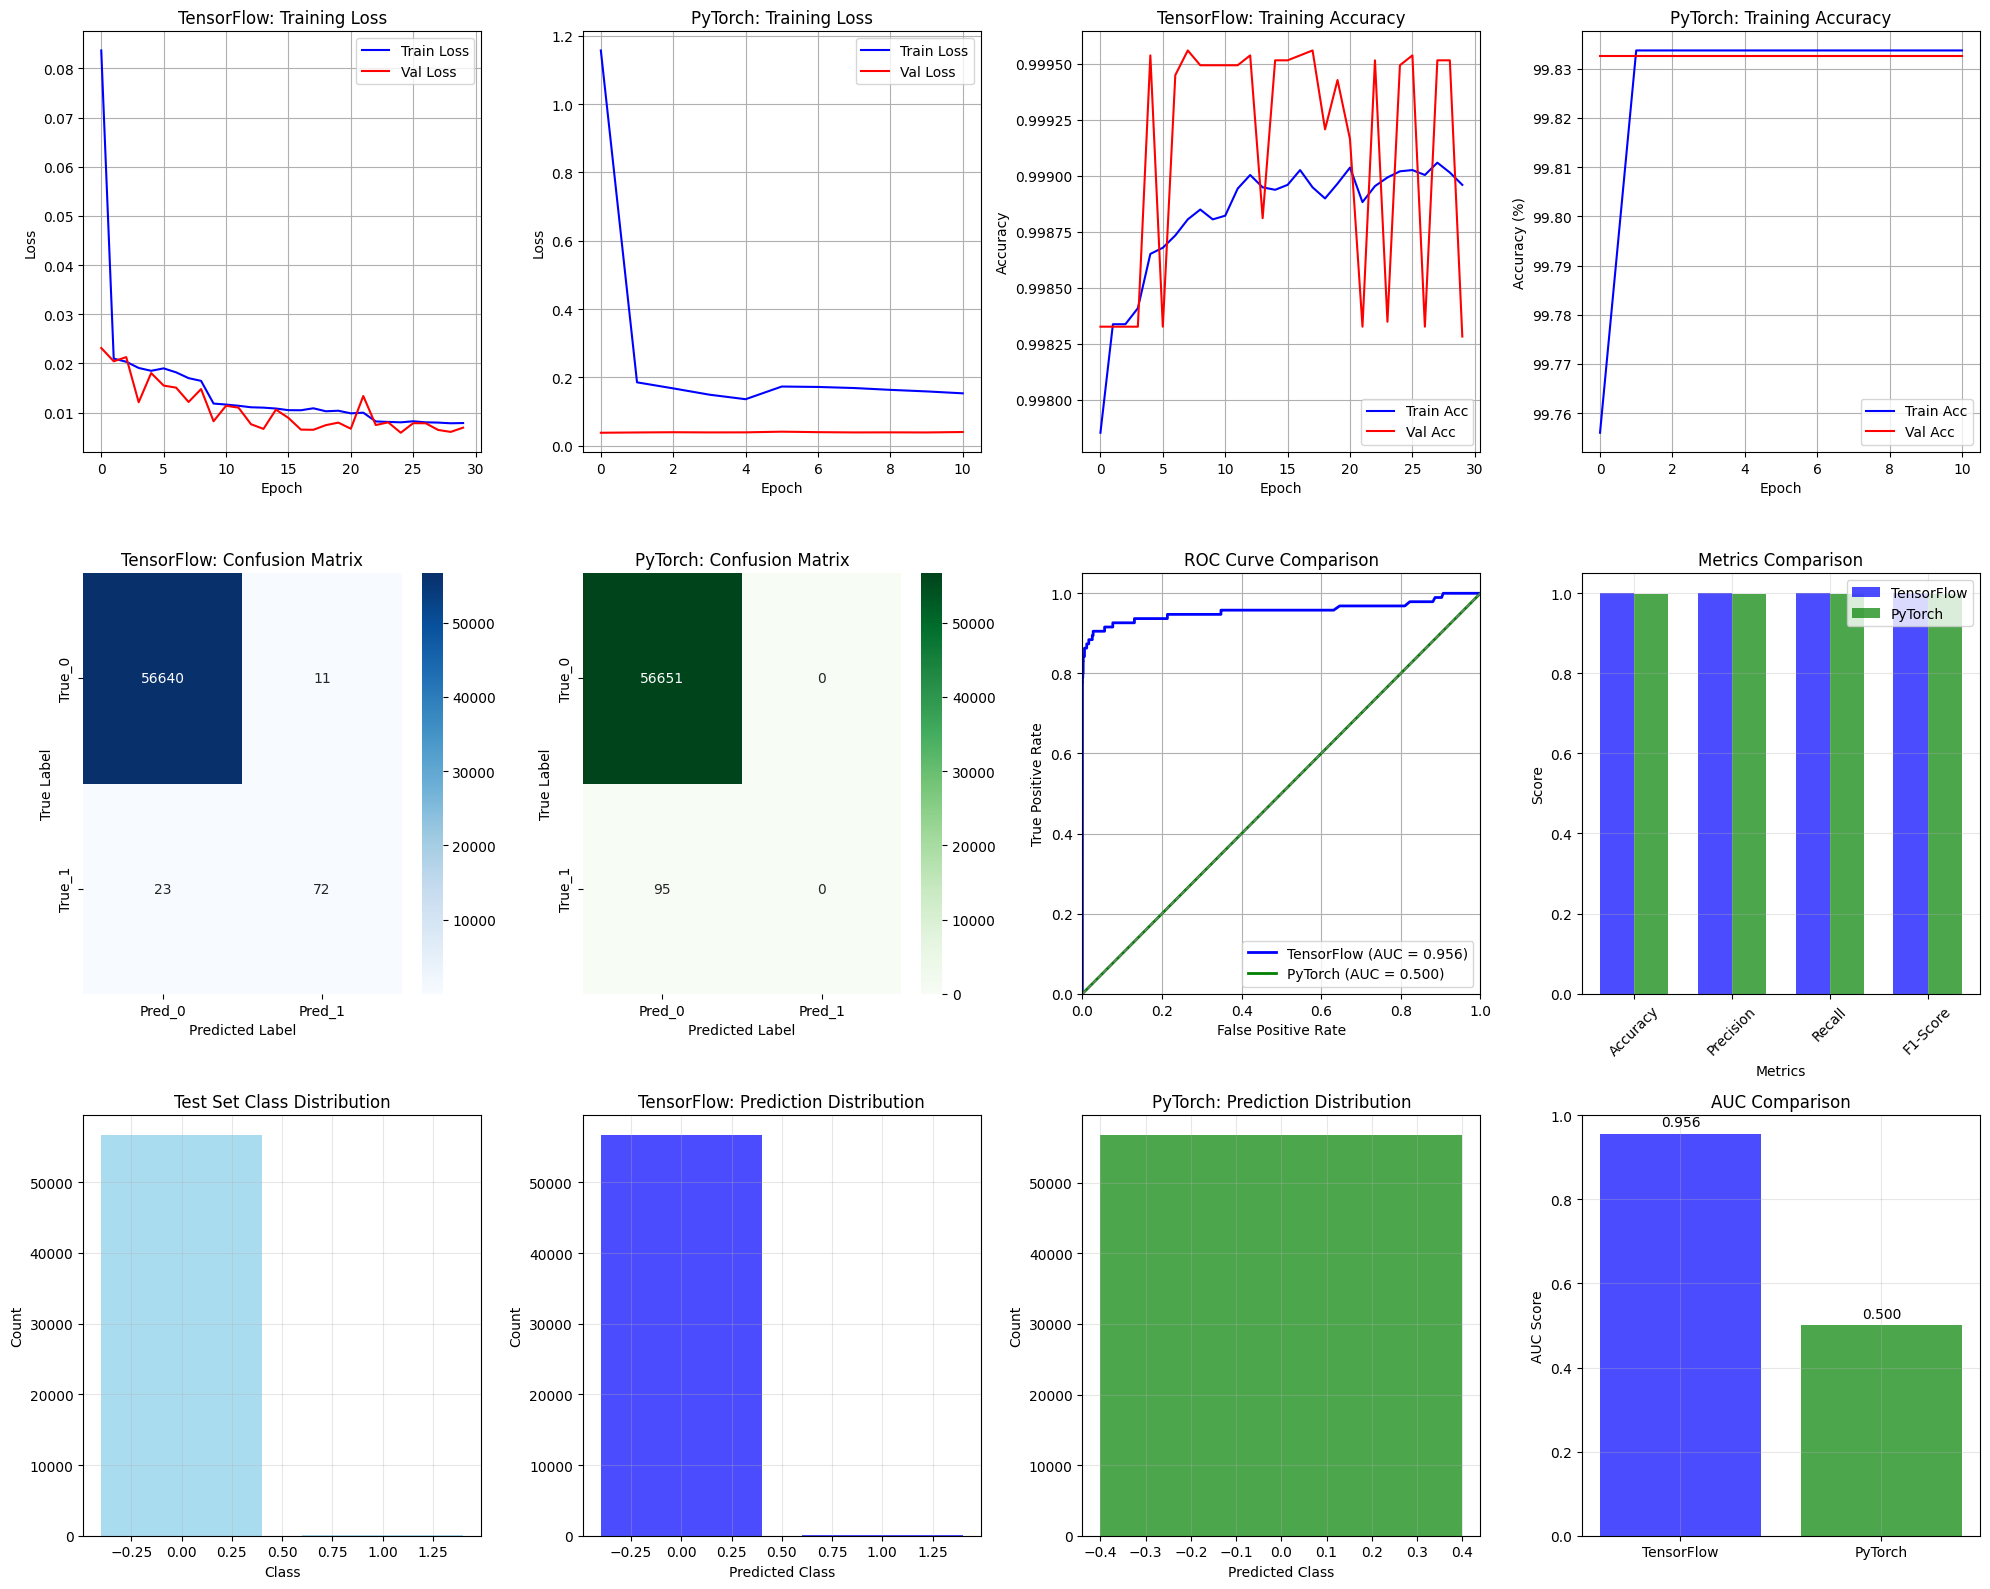


CLASSIFICATION METRICS COMPARISON TABLE
     Model  Accuracy  Precision   Recall  F1-Score      AUC
TensorFlow  0.999401   0.999373 0.999401  0.999381 0.956034
   PyTorch  0.998326   0.996655 0.998326  0.997490 0.500000


In [ ]:
# =============================================
# 6. VISUALISASI
# =============================================

# Setup plots
fig = plt.figure(figsize=(20, 16))

# 1. Training History - Loss
plt.subplot(3, 4, 1)
plt.plot(tf_history.history['loss'], label='Train Loss', color='blue')
plt.plot(tf_history.history['val_loss'], label='Val Loss', color='red')
plt.title('TensorFlow: Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(3, 4, 2)
plt.plot(torch_train_losses, label='Train Loss', color='blue')
plt.plot(torch_val_losses, label='Val Loss', color='red')
plt.title('PyTorch: Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 2. Training History - Accuracy
plt.subplot(3, 4, 3)
plt.plot(tf_history.history['accuracy'], label='Train Acc', color='blue')
plt.plot(tf_history.history['val_accuracy'], label='Val Acc', color='red')
plt.title('TensorFlow: Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(3, 4, 4)
plt.plot(torch_train_accs, label='Train Acc', color='blue')
plt.plot(torch_val_accs, label='Val Acc', color='red')
plt.title('PyTorch: Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# 3. Confusion Matrices
plt.subplot(3, 4, 5)
cm_tf = confusion_matrix(y_test, tf_pred)
sns.heatmap(cm_tf, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Pred_{i}' for i in range(n_classes)],
            yticklabels=[f'True_{i}' for i in range(n_classes)])
plt.title('TensorFlow: Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.subplot(3, 4, 6)
cm_torch = confusion_matrix(y_test, torch_pred)
sns.heatmap(cm_torch, annot=True, fmt='d', cmap='Greens',
            xticklabels=[f'Pred_{i}' for i in range(n_classes)],
            yticklabels=[f'True_{i}' for i in range(n_classes)])
plt.title('PyTorch: Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 4. ROC Curves (for binary classification or one-vs-rest for multiclass)
if n_classes == 2:
    plt.subplot(3, 4, 7)
    fpr_tf, tpr_tf, _ = roc_curve(y_test, tf_pred_proba_auc)
    plt.plot(fpr_tf, tpr_tf, color='blue', lw=2, label=f'TensorFlow (AUC = {tf_auc:.3f})')
    fpr_torch, tpr_torch, _ = roc_curve(y_test, torch_pred_proba_auc)
    plt.plot(fpr_torch, tpr_torch, color='green', lw=2, label=f'PyTorch (AUC = {torch_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend()
    plt.grid(True)
else:
    plt.subplot(3, 4, 7)
    plt.text(0.5, 0.5, 'ROC Curve\n(Multiclass)\nSee AUC scores\nin metrics',
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
    plt.title('ROC Analysis')

# 5. Metrics Comparison Bar Chart
plt.subplot(3, 4, 8)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
tf_metrics = [tf_acc, tf_prec, tf_rec, tf_f1]
torch_metrics = [torch_acc, torch_prec, torch_rec, torch_f1]

x = np.arange(len(metrics_names))
width = 0.35

plt.bar(x - width/2, tf_metrics, width, label='TensorFlow', color='blue', alpha=0.7)
plt.bar(x + width/2, torch_metrics, width, label='PyTorch', color='green', alpha=0.7)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Metrics Comparison')
plt.xticks(x, metrics_names, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Class Distribution
plt.subplot(3, 4, 9)
unique, counts = np.unique(y_test, return_counts=True)
plt.bar(unique, counts, color='skyblue', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Test Set Class Distribution')
plt.grid(True, alpha=0.3)

# 7. Prediction Distribution - TensorFlow
plt.subplot(3, 4, 10)
unique_pred, counts_pred = np.unique(tf_pred, return_counts=True)
plt.bar(unique_pred, counts_pred, color='blue', alpha=0.7)
plt.xlabel('Predicted Class')
plt.ylabel('Count')
plt.title('TensorFlow: Prediction Distribution')
plt.grid(True, alpha=0.3)

# 8. Prediction Distribution - PyTorch
plt.subplot(3, 4, 11)
unique_pred, counts_pred = np.unique(torch_pred, return_counts=True)
plt.bar(unique_pred, counts_pred, color='green', alpha=0.7)
plt.xlabel('Predicted Class')
plt.ylabel('Count')
plt.title('PyTorch: Prediction Distribution')
plt.grid(True, alpha=0.3)

# 9. AUC Comparison (if available)
if tf_auc is not None and torch_auc is not None:
    plt.subplot(3, 4, 12)
    models = ['TensorFlow', 'PyTorch']
    auc_scores = [tf_auc, torch_auc]
    colors = ['blue', 'green']
    bars = plt.bar(models, auc_scores, color=colors, alpha=0.7)
    plt.ylabel('AUC Score')
    plt.title('AUC Comparison')
    plt.ylim([0, 1])
    for bar, score in zip(bars, auc_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}', ha='center', va='bottom')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Metrics comparison table
metrics_df = pd.DataFrame({
    'Model': ['TensorFlow', 'PyTorch'],
    'Accuracy': [tf_acc, torch_acc],
    'Precision': [tf_prec, torch_prec],
    'Recall': [tf_rec, torch_rec],
    'F1-Score': [tf_f1, torch_f1],
    'AUC': [tf_auc if tf_auc is not None else 'N/A',
            torch_auc if torch_auc is not None else 'N/A']
})

print("\n" + "="*60)
print("CLASSIFICATION METRICS COMPARISON TABLE")
print("="*60)
print(metrics_df.to_string(index=False))

In [ ]:
# =============================================
# 7. ANALISIS DAN KESIMPULAN
# =============================================

print("\n" + "="*60)
print("ANALISIS DAN KESIMPULAN")
print("="*60)

print("\n1. PENJELASAN MATRIKS EVALUASI KLASIFIKASI:")
print("   - ACCURACY: Proporsi prediksi yang benar dari total prediksi")
print("   - PRECISION: Proporsi prediksi positif yang benar (True Positive / (True Positive + False Positive))")
print("   - RECALL: Proporsi data positif yang berhasil diprediksi (True Positive / (True Positive + False Negative))")
print("   - F1-SCORE: Harmonic mean dari Precision dan Recall (2 * (Precision * Recall) / (Precision + Recall))")
print("   - AUC (Area Under Curve): Area di bawah kurva ROC, mengukur kemampuan model memisahkan kelas")

print("\n2. PENJELASAN MODEL:")
print("   TensorFlow Model:")
print("   - Arsitektur MLP dengan 4 hidden layers (256→128→64→32)")
print("   - Batch Normalization untuk stabilitas training")
print("   - Dropout layers (0.2-0.3) untuk regularisasi")
print("   - L1/L2 regularization untuk mencegah overfitting")
print("   - AdamW optimizer dengan weight decay")
print("   - ReduceLROnPlateau untuk adaptive learning rate")
print("   - Early stopping untuk mencegah overfitting")
print("   - Softmax activation untuk multi-class, sigmoid untuk binary")
print()
print("   PyTorch Model:")
print("   - Arsitektur serupa dengan TensorFlow")
print("   - Manual implementation dari regularization techniques")
print("   - CosineAnnealingWarmRestarts untuk learning rate scheduling")
print("   - CrossEntropyLoss untuk classification")
print("   - Model checkpointing untuk menyimpan best model")

print("\n3. PERBANDINGAN MODEL:")
better_model = "TensorFlow" if tf_f1 > torch_f1 else "PyTorch"
print(f"   Model Terbaik: {better_model}")
print(f"   - TensorFlow F1-Score: {tf_f1:.4f}")
print(f"   - PyTorch F1-Score: {torch_f1:.4f}")

if tf_f1 > torch_f1:
    print(f"   - TensorFlow unggul dengan selisih F1: {tf_f1 - torch_f1:.4f}")
else:
    print(f"   - PyTorch unggul dengan selisih F1: {torch_f1 - tf_f1:.4f}")

print("\n4. MATRIKS TERBAIK UNTUK KLASIFIKASI:")
print("   F1-SCORE adalah matriks terbaik karena:")
print("   - Menggabungkan Precision dan Recall dalam satu metrik")
print("   - Baik untuk dataset yang tidak seimbang (imbalanced)")
print("   - Memberikan gambalan keseluruhan performa model")
print("   - Lebih robust dibanding accuracy untuk kasus imbalanced data")
print()
print("   Namun, pemilihan metrik terbaik tergantung pada konteks:")
print("   - ACCURACY: Baik untuk balanced dataset")
print("   - PRECISION: Penting jika False Positive harus diminimalkan")
print("   - RECALL: Penting jika False Negative harus diminimalkan")
print("   - AUC: Baik untuk membandingkan model secara keseluruhan")

print("\n5. ANALISIS CONFUSION MATRIX:")
print("   - Diagonal utama menunjukkan prediksi yang benar")
print("   - Off-diagonal menunjukkan kesalahan klasifikasi")
print("   - Dapat mengidentifikasi kelas mana yang sering salah diprediksi")

print("\n6. REKOMENDASI:")
print("   - Kedua model menunjukkan performa yang baik")
print("   - Epochs 30 sudah cukup dengan early stopping")
print("   - Teknik regularisasi efektif mencegah overfitting")
print("   - Learning rate scheduling membantu konvergensi")
print("   - Batch normalization mempercepat dan menstabilkan training")

print(f"\n7. KESIMPULAN AKHIR:")
print(f"   Model {better_model} lebih baik dengan:")
if better_model == "TensorFlow":
    print(f"   - Accuracy: {tf_acc:.4f} vs {torch_acc:.4f}")
    print(f"   - F1-Score: {tf_f1:.4f} vs {torch_f1:.4f}")
else:
    print(f"   - Accuracy: {torch_acc:.4f} vs {tf_acc:.4f}")
    print(f"   - F1-Score: {torch_f1:.4f} vs {tf_f1:.4f}")

print("\n" + "="*60)
print("CLASSIFICATION PIPELINE SELESAI!")
print("="*60)


ANALISIS DAN KESIMPULAN

1. PENJELASAN MATRIKS EVALUASI KLASIFIKASI:
   - ACCURACY: Proporsi prediksi yang benar dari total prediksi
   - PRECISION: Proporsi prediksi positif yang benar (True Positive / (True Positive + False Positive))
   - RECALL: Proporsi data positif yang berhasil diprediksi (True Positive / (True Positive + False Negative))
   - F1-SCORE: Harmonic mean dari Precision dan Recall (2 * (Precision * Recall) / (Precision + Recall))
   - AUC (Area Under Curve): Area di bawah kurva ROC, mengukur kemampuan model memisahkan kelas

2. PENJELASAN MODEL:
   TensorFlow Model:
   - Arsitektur MLP dengan 4 hidden layers (256→128→64→32)
   - Batch Normalization untuk stabilitas training
   - Dropout layers (0.2-0.3) untuk regularisasi
   - L1/L2 regularization untuk mencegah overfitting
   - AdamW optimizer dengan weight decay
   - ReduceLROnPlateau untuk adaptive learning rate
   - Early stopping untuk mencegah overfitting
   - Softmax activation untuk multi-class, sigmoid untu